## This is the 2-layer neural network workbook for ECE 239AS Assignment #3

Please follow the notebook linearly to implement a two layer neural network.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a two layer neural network.

In [16]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Toy example

Before loading CIFAR-10, there will be a toy example to test your implementation of the forward and backward pass

In [17]:
from nndl.neural_net import TwoLayerNet

In [18]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

### Compute forward pass scores

In [19]:
## Implement the forward pass of the neural network.

# Note, there is a statement if y is None: return scores, which is why 
# the following call will calculate the scores.
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
    [-1.07260209,  0.05083871, -0.87253915],
    [-2.02778743, -0.10832494, -1.52641362],
    [-0.74225908,  0.15259725, -0.39578548],
    [-0.38172726,  0.10835902, -0.17328274],
    [-0.64417314, -0.18886813, -0.41106892]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

correct scores:
[[-1.07260209  0.05083871 -0.87253915]
 [-2.02778743 -0.10832494 -1.52641362]
 [-0.74225908  0.15259725 -0.39578548]
 [-0.38172726  0.10835902 -0.17328274]
 [-0.64417314 -0.18886813 -0.41106892]]

Difference between your scores and correct scores:
3.381231248461569e-08


### Forward pass loss

In [20]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.071696123862817

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.0


In [21]:
print(loss)

1.071696123862817


### Backward pass

Implements the backwards pass of the neural network.  Check your gradients with the gradient check utilities provided.

In [22]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('{} max relative error: {}'.format(param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 1.2482660547101085e-09
W2 max relative error: 2.9632227682005116e-10
b1 max relative error: 3.1726806716844575e-09
W1 max relative error: 1.2832874456864775e-09


### Training the network

Implement neural_net.train() to train the network via stochastic gradient descent, much like the softmax and SVM.

Final training loss:  0.014497864587765906


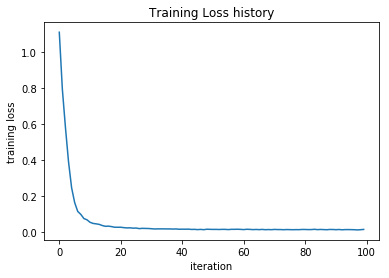

In [23]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Classify CIFAR-10

Do classification on the CIFAR-10 dataset.

In [24]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### Running SGD

If your implementation is correct, you should see a validation accuracy of around 28-29%.

In [25]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

# Save this net as the variable subopt_net for later comparison.
subopt_net = net

iteration 0 / 1000: loss 2.302757518613176
iteration 100 / 1000: loss 2.302120159207236
iteration 200 / 1000: loss 2.2956136007408703
iteration 300 / 1000: loss 2.251825904316413
iteration 400 / 1000: loss 2.188995235046776
iteration 500 / 1000: loss 2.1162527791897747
iteration 600 / 1000: loss 2.064670827698217
iteration 700 / 1000: loss 1.9901688623083942
iteration 800 / 1000: loss 2.002827640124685
iteration 900 / 1000: loss 1.9465176817856495
Validation accuracy:  0.283


## Questions:

The training accuracy isn't great.  

(1) What are some of the reasons why this is the case?  Take the following cell to do some analyses and then report your answers in the cell following the one below.

(2) How should you fix the problems you identified in (1)?


In [26]:
stats['train_acc_history']

[0.095, 0.15, 0.25, 0.25, 0.315]

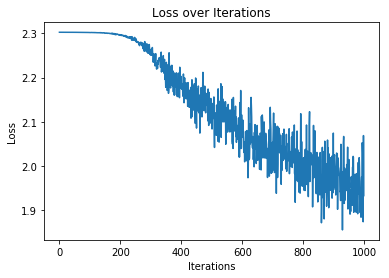

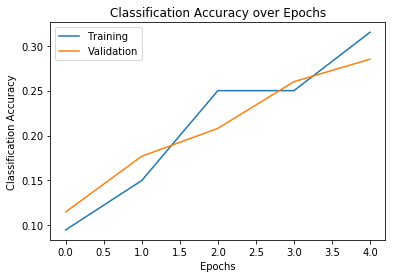

In [27]:
# ================================================================ #
# YOUR CODE HERE:
#   Do some debugging to gain some insight into why the optimization
#   isn't great.
# ================================================================ #

# Plot the loss function and train / validation accuracies
plt.subplot()
plt.plot(stats['loss_history'])
plt.title('Loss over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

plt.subplot()
plt.plot(stats['train_acc_history'], label="Training")
plt.plot(stats['val_acc_history'], label="Validation")
plt.title('Classification Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Classification Accuracy')
plt.legend()
plt.show()

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

## Optimize the neural network

Use the following part of the Jupyter notebook to optimize your hyperparameters on the validation set.  Store your nets as best_net.

In [28]:
best_net = None # store the best model into this 

# ================================================================ #
# YOUR CODE HERE:
#   Optimize over your hyperparameters to arrive at the best neural
#   network.  You should be able to get over 50% validation accuracy.
#   For this part of the notebook, we will give credit based on the
#   accuracy you get.  Your score on this question will be multiplied by:
#      min(floor((X - 28%)) / %22, 1) 
#   where if you get 50% or higher validation accuracy, you get full
#   points.
#
#   Note, you need to use the same network structure (keep hidden_size = 50)!
# ================================================================ #

best_val_acc = 0
best_learning_rate = None
best_reg = None

val_accs = []
learning_rates = [1e-3, 2.5e-3]
reg = [0.275, 0.3, 0.325]
for a in learning_rates:      
    for r in reg:
        net = TwoLayerNet(input_size, hidden_size, num_classes)
        # Train the network
        stats = net.train(X_train, y_train, X_val, y_val,
                    num_iters=1500, batch_size=200,
                    learning_rate=a, learning_rate_decay=0.95,
                    reg=r, verbose=True)

        # Predict on the validation set
        val_acc = (net.predict(X_val) == y_val).mean()
        print('Validation accuracy: ', val_acc)
        print('a and r:', a, r)
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_net = net
            best_learning_rate = a
            best_reg = r

#         plt.subplot()
#         plt.plot(stats['loss_history'])
#         plt.title('Loss over Iterations')
#         plt.xlabel('Iterations')
#         plt.ylabel('Loss')
#         plt.show()

#         plt.subplot()
#         plt.plot(stats['train_acc_history'], label="Training")
#         plt.plot(stats['val_acc_history'], label="Validation")
#         plt.title('Classification Accuracy over Epochs')
#         plt.xlabel('Epochs')
#         plt.ylabel('Classification Accuracy')
#         plt.legend()
#         plt.show()

print('validation accuracies:', val_accs)
print('best_net:', best_net)

# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #

iteration 0 / 1500: loss 2.302785940490577
iteration 100 / 1500: loss 1.921941279057944
iteration 200 / 1500: loss 1.7459775370097925
iteration 300 / 1500: loss 1.7853707093552746
iteration 400 / 1500: loss 1.6409050818538014
iteration 500 / 1500: loss 1.7367370225272531
iteration 600 / 1500: loss 1.5735369134815005
iteration 700 / 1500: loss 1.5599814728693466
iteration 800 / 1500: loss 1.538410454485706
iteration 900 / 1500: loss 1.6128938044875434
iteration 1000 / 1500: loss 1.4505347590376791
iteration 1100 / 1500: loss 1.4299335259180648
iteration 1200 / 1500: loss 1.4431226057192421
iteration 1300 / 1500: loss 1.4879765133715503
iteration 1400 / 1500: loss 1.5204604449333112
Validation accuracy:  0.496
a and r: 0.001 0.275
iteration 0 / 1500: loss 2.302809635010588
iteration 100 / 1500: loss 1.947771229505394
iteration 200 / 1500: loss 1.7580641618263197
iteration 300 / 1500: loss 1.7219527863859656
iteration 400 / 1500: loss 1.6594319061925744
iteration 500 / 1500: loss 1.577525

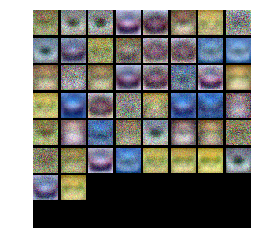

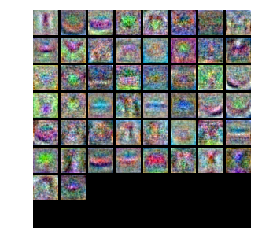

In [29]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.T.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(subopt_net)
show_net_weights(best_net)

(1) What differences do you see in the weights between the suboptimal net and the best net you arrived at?

## Evaluate on test set 

In [30]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.451
